# 이론 정리

## 세션이란

HTTP는 Connectionless와 Stateless  
Connectionless(비 연결지향)  
-> 클라이언트에서 서버에 요청을 보내면 서버는 클라이언트에 응답을 하고 접속을 끊는 특성  


# Step 0. 데이터 준비

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해보자  
```
1) wget으로 데이터 다운로드
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

2) 다운받은 데이터를 작업디렉토리로 이동
$ mv ml-1m.zip ~/aiffel/yoochoose-data

3) 압축 해제
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip
```

In [1]:
import datetime as dt
from pathlib import Path
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [44]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', 
                       header=None, 
                       usecols=[0, 1, 2, 3], 
                       dtype={0: np.int32, 
                              1: np.int32, 
                              2: np.int32}, 
                       nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


+ 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다.  
  이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.
  

+ Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다.  
  하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다.  
  아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.
  

+ Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.  
  위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.
  
  

In [3]:
type(data)

pandas.core.frame.DataFrame

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

# Step 1. 데이터의 전처리 & 톺아보기

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서  
항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.  
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
session_length.max()

2314

In [7]:
type(session_length)

pandas.core.series.Series

여기서 session_length란 각각의 UserId가 rating한 영화 개수이다.

In [8]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [9]:
session_length.min(), session_length.max()

(20, 2314)

In [10]:
session_length.quantile(0.999)

1343.181000000005

평점 준 영화 개수에서  
중간값 : 96  
평균 : 165.60  
최소 : 20  
최대 : 2314  
구간 99.9% : 1343.18  
이다.  

각 유저가 시청한 영화는 96~166 정도인데  
99.9% 세션은 길이가 1343개 입니다.  
길이가 1000이상인 세션을 살펴보자

## 가장 많은 평점을 남긴 UserId

+ 가장 많은 평점을 남긴 UserId를 long_session에 저장

In [24]:
# max였던 2314개의 영화를 내린 사람
long_session = session_length[session_length==2314].index[0]
df_tmp = data[data['UserId']==long_session]
df_tmp

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-04 05:09:52
697168,4169,2617,4,2000-08-04 05:09:52
697185,4169,2628,4,2000-08-04 05:09:52
697219,4169,2653,4,2000-08-04 05:09:52
697275,4169,423,3,2000-08-04 05:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-16 05:52:27
695702,4169,1413,3,2002-06-16 06:03:51
697358,4169,494,4,2002-06-16 06:16:00
695945,4169,1804,2,2002-06-16 06:16:23


## 세션 길이에 대한 시각화

같은 시간동안 rating을 남긴 영화들이 존재한다.  
이렇게 긴 세션을 제거할 수도 포함할 수도 있다.  
세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화해보자.  

In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

cumsum() : 각 원소들의 누적 합을 표시함. 각 row와 column의 구분은 없어지고, 순서대로 sum을 함.  
참조 = https://m.blog.naver.com/PostView.nhn?blogId=allenpython&logNo=220401132533&proxyReferer=https:%2F%2Fwww.google.com%2F  

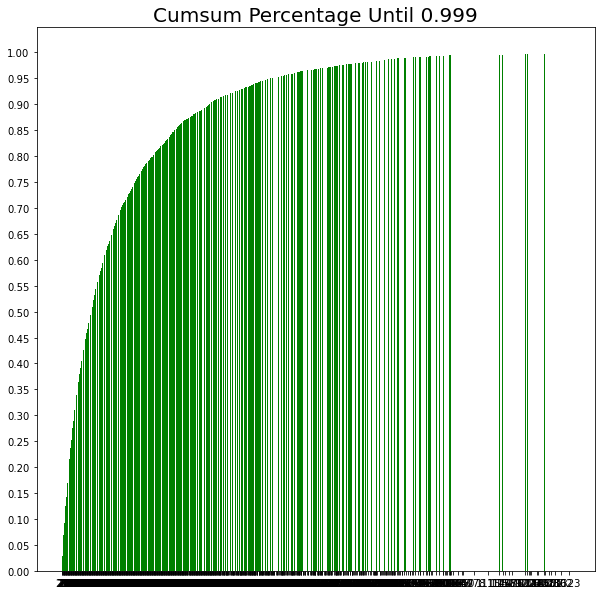

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='green')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

**Q.추천 시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는 Matrix Factorization 모델을 널리 사용합니다.  
그렇다면 이 데이터도 유저와 클릭한 상품정보 관계에 대해 Matrix Factorization을 사용하면 어떨까요?**  
>User * Item Matrix의 빈칸이 너무 많아서(data sparsity)   
모델이 제대로 학습되지 않을 가능성이 있다.     
이 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에    
세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태가 된다.

## Session Time

영화 장르의 소비 패턴은 금방금방 변합니다.  
데이터가 발생한 시간에 대해 알아봅시다.  
**Q2. 추천 시스템에서 다루는 시간 관련 데이터는 다양한 측면이 있습니다. 데이터 생성 날짜 말고 또 어떤 요소가 있을까요?**  
>접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등  

그렇다면 우리가 다루려는 데이터의 시간 관련 정보를 확인해 봅시다.

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [15]:
956703932/60/60/24/365

30.33688267376966

In [16]:
0.3*12

3.5999999999999996

계산을 통해 알아낸 가장 첫번째 시간은 2000년대 3월 중순의이라고 나온다

In [17]:
1046454590/60/60/24/365

33.18285736935565

In [18]:
(1036353590/60/60/24/365-32)*12

10.35068112633175

마지막 날은 2003년 10월 초이다.
2년치가 넘는 데이터이다.  
노드에서는 한달치만 사용해도 500백만개였지만 모든 데이터의 갯수가 100만개 정도니까 모두 사용하기로 한다.

In [31]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


In [32]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습니다.날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용합니다.

In [33]:
print(dt.timedelta(30))

30 days, 0:00:00


In [34]:
month_ago = latest - dt.timedelta(30)  

In [35]:
print(type(month_ago))
month_ago

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2003-01-30 02:49:50')

In [19]:
type(latest)

numpy.int64

노드와는 다르게 Timestamp가 아니고 numpy이다.  
UTC-TIME이기 때문이다. 이것을 노드처럼 timestamp의 형태로 바꿔보자.

## UTC-TIME -> timestamp

In [45]:
# 시간 변환
import datetime, time
times = data["Time"] 
tmp_list = [] 
for time in times: 
    tmp_date = dt.datetime.fromtimestamp(time)
    tmp_list.append(tmp_date)
data["Time"] = tmp_list 
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


In [21]:
data['UserId'].nunique()

6040

In [22]:
data['ItemId'].nunique()

3706

유저(UserId)는 6040명  
영화(ItemId)는 3706개이다  

## 영화별 리뷰 횟수

In [26]:
item_length = data.groupby('ItemId').size()
item_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [27]:
item_length.median(), item_length.mean(), item_length.min(), item_length.max()

(123.5, 269.88909875876953, 1, 3428)

In [28]:
item_length.quantile(0.999)

2734.2450000001113

평점 받은 영화 중에서 리뷰 횟수는    
중간값 : 123.5  (???)
평균 : 269.89 
최소 : 1 
최대 : 3428 
구간 99.9% : 2734.25 
이다.  

## 1번씩만 리뷰된 영화

In [61]:
rare_movie = []
for ItemId in item_length:
    if ItemId==1:
        rare_movie.append(ItemId)
        
print(len(rare_movie))

114


114개의 영화는 한번씩만 rating이 된 영화이다.  
이 영화들의 데이터를 살릴지 없앨지 고민해보자

## 가장 많은 리뷰를 받은 영화

In [30]:
# max였던 3428개의 리뷰가 있는 영화
lots_review = item_length[item_length==3428].index[0]
df_tmp_2 = data[data['ItemId']==lots_review]
df_tmp_2

,UserId,ItemId,Rating,Time
105,2,2858,4,2001-01-01 06:33:54
202,3,2858,4,2001-01-01 06:10:39
299,5,2858,4,2000-12-31 14:43:10
471,6,2858,1,2000-12-31 13:26:49
585,8,2858,5,2000-12-31 11:30:17
...,...,...,...,...
996998,6019,2858,5,2000-04-26 23:49:12
997895,6027,2858,3,2000-04-26 14:25:36
998845,6036,2858,5,2000-04-26 09:37:33
999571,6037,2858,4,2000-04-26 09:33:35


In [39]:
rating = df_tmp_2.groupby('Rating').size()
rating

Rating
1      83
2     134
3     358
4     890
5    1963
dtype: int64

간단하게 살펴보아도 대체적으로 높은 평점을 받았지만  
4, 5점이 대부분이지만 1,2,3도 적지 않다는 것을 알 수 있다.  

## Train/ Valid/ Test split

이 프로젝트에서는 UserId에서 아래처럼 무작위로 뽑아서 split하는 것이 더 데이터를 훈련시킬때 관계가 

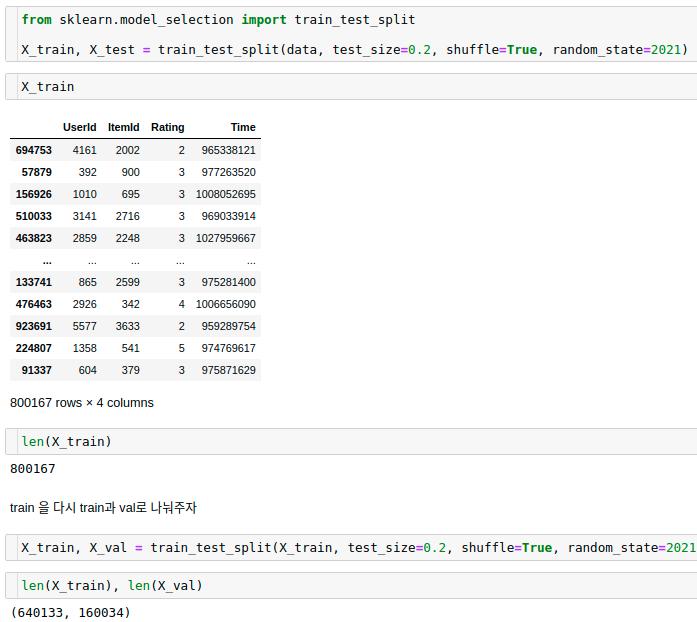

## Data Cleansing

위에서 1인 세션도 꽤 있습니다.   
우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해줍니다.  
너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해줍니다.  

In [60]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

## 유저 아이디 중 평점횟수가 적은 유저 제거(즉 전문가가 아닌 유저 제거)
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

## 영화중 평점의 횟수가 적은 영화 제거(즉 비주류의 영화 제거)
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [58]:
# ## 리뷰가 3점 이하인 리뷰는 제거
# def cleanse_short_rating_session(data: pd.DataFrame, shortest):
#     if data['Rating']>=int(shortest):
#         rating = data
#     high_rating = rating.index
#     data = data[data['Rating'].isin(high_rating)]
#     return data

In [61]:
# data_rating = cleanse_short_rating_session(data, 4)
# data_rating

**평점 준 영화 개수의**  
중간값 : 96  
평균 : 165.60  
최소 : 20  
최대 : 2314  
구간 99.9% : 1343.18  
이다.
  
**평점 받은 영화 중에서 리뷰 횟수의**     
중간값 : 123.5  
평균 : 269.89 
최소 : 1 
최대 : 3428 
구간 99.9% : 2734.25  
이다.

유저 중에서 평점을 90개 이상 남긴 사람과 리뷰 수가 200개 이상인 영화의 교집합만 추려낸다

In [62]:
data = cleanse_recursive(data, shortest=90, least_click=200)
data

,UserId,ItemId,Rating,Time
130,2,1198,4,2001-01-01 06:28:44
64,2,1210,4,2001-01-01 06:29:11
71,2,1217,3,2001-01-01 06:29:11
134,2,2717,3,2001-01-01 06:29:56
88,2,1293,5,2001-01-01 06:31:01
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


# Step 2. 미니 배치의 구성

실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다.  
Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.  
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## 데이터 분리하기

In [63]:
session_last_time = data.groupby('UserId')['Time'].max()

session_last_time

UserId
2      2001-01-01 07:02:54
5      2000-12-31 16:09:45
8      2000-12-31 16:19:03
9      2000-12-31 10:37:58
10     2001-01-28 08:37:13
               ...        
6035   2000-04-26 10:47:20
6036   2000-04-26 22:19:56
6037   2000-04-27 11:17:20
6039   2000-04-26 23:07:09
6040   2001-08-20 22:44:15
Name: Time, Length: 2867, dtype: datetime64[ns]

In [64]:
final_time = data['Time'].max()
final_time

Timestamp('2003-03-01 02:49:50')

## 데이터 분리함수 split_by_date

In [65]:
def split_by_date(data: pd.DataFrame, n_days: int):
     #마지막날 = session_last_time
    final_time = data['Time'].max()
    # 세션아이디기준 time이 마지막인날
    session_last_time = data.groupby('UserId')['Time'].max()
    
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [66]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [67]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["UserId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [68]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 578485
	 Sessions: 2564
	 Items: 2564
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-08-06 14:21:37

* valid Set Stats Info
	 Events: 28525
	 Sessions: 85
	 Items: 85
	 First Time : 2000-04-28 01:38:08
	 Last Time : 2002-11-18 05:59:23

* test Set Stats Info
	 Events: 80530
	 Sessions: 218
	 Items: 218
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



In [69]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

이제 데이터를 저장하고 data pipeline을 구축하는 단계로 넘어가자

In [70]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 3. 모델 구성

노드를 참조해서 모델을 구성해보자

## 1) SessionDataset 

데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [75]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만듬  
click_offsets 변수 -> 각 세션이 시작된 인덱스  
session_idx 변수 -> 각 세션을 인덱싱한 np.array 입니다.  

In [76]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
106,2,1225,5,2001-01-01 06:33:11,5
120,2,1193,5,2001-01-01 06:33:33,6
172,2,318,5,2001-01-01 06:33:33,7
105,2,2858,4,2001-01-01 06:33:54,8
67,2,1213,2,2001-01-01 06:34:18,9


In [77]:
tr_dataset.click_offsets

array([     0,    120,    261, ..., 578102, 578206, 578485], dtype=int32)

In [78]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2561, 2562, 2563])

## 2) SessionDataLoader

iterator, generator -> [이 자료](https://dojang.io/mod/page/view.php?id=2405) 먼저 보기  

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.  
\_\_iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.  
mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다  

In [79]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=20):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [80]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
106,2,1225,5,2001-01-01 06:33:11,5
120,2,1193,5,2001-01-01 06:33:33,6
172,2,318,5,2001-01-01 06:33:33,7
105,2,2858,4,2001-01-01 06:33:54,8
67,2,1213,2,2001-01-01 06:34:18,9


In [81]:
iter_ex = iter(tr_data_loader)
iter_ex

<generator object SessionDataLoader.__iter__ at 0x7fb33e5a6f50>

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.  
input, output, mask의 감 잡기

In [82]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0   3   1 308]
Label Item Idx are :       [  1 120 241 309]
Previous Masked Input Idx are []


# Step 4. 모델 학습

## Evaluation Metric

In [95]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.  
학습 진행률을 모니터링하기 위해 사용하는 tqdm 라이브러리가 설치되어 있지 않다면 다음과 같이 설치해 주세요.  
```
$ pip install tqdm
```

In [83]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [84]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리

In [86]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

## 다양한 하이퍼파라미터

In [102]:
# batch_size 다르게
args01 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args02 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
# epoch을 다르게
args03 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [103]:
model01 = create_model(args01)
model02 = create_model(args02)
model03 = create_model(args03)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 1294)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    201900    
_________________________________________________________________
dropout_3 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (128, 1294)               65994     
Total params: 267,894
Trainable params: 267,894
Non-trainable params: 0
_________________________________________________________________
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 1294)]           0         
____________________________________

# Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인  


In [96]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

**test_model 함수**

In [97]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

## model01

In [93]:
train_model(model01, args01)

Evaluation:   0%|          | 0/222 [00:00<?, ?it/s]


IndexError: index 85 is out of bounds for axis 0 with size 85

batch_size가 커서인지 에러가 뜬다.

## model02

In [98]:
train_model(model02, args02)

Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.14]

	 - Recall@20 epoch 1: 0.337431
	 - MRR@20    epoch 1: 0.095869



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.141, train_loss=4.72] 

	 - Recall@20 epoch 2: 0.351111
	 - MRR@20    epoch 2: 0.102880



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.109, train_loss=4.69] 

	 - Recall@20 epoch 3: 0.358889
	 - MRR@20    epoch 3: 0.107527



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.66]

	 - Recall@20 epoch 4: 0.362917
	 - MRR@20    epoch 4: 0.109525



Evaluation:  51%|█████     | 225/444 [00:52<00:51,  4.27it/s]

	 - Recall@20 epoch 5: 0.363125
	 - MRR@20    epoch 5: 0.110999



In [99]:
test_model(model02, args02, test)

Evaluation:  83%|████████▎ | 1043/1254 [04:02<00:49,  4.30it/s]

	 - Recall@20: 0.314822
	 - MRR@20: 0.092881



## model03

In [100]:
train_model(model03, args03)

Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.01]

	 - Recall@20 epoch 1: 0.285000
	 - MRR@20    epoch 1: 0.074632



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.68]

	 - Recall@20 epoch 2: 0.335208
	 - MRR@20    epoch 2: 0.093602



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.7] 

	 - Recall@20 epoch 3: 0.347431
	 - MRR@20    epoch 3: 0.100628



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.03]

	 - Recall@20 epoch 4: 0.358194
	 - MRR@20    epoch 4: 0.104201



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.55]

	 - Recall@20 epoch 5: 0.359861
	 - MRR@20    epoch 5: 0.106467



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.54]

	 - Recall@20 epoch 6: 0.362083
	 - MRR@20    epoch 6: 0.107948



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.08]

	 - Recall@20 epoch 7: 0.365556
	 - MRR@20    epoch 7: 0.108452



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.75]

	 - Recall@20 epoch 8: 0.366944
	 - MRR@20    epoch 8: 0.108983



Train:   0%|          | 0/8998 [00:00<?, ?it/s, accuracy=0.141, train_loss=4.39] 

	 - Recall@20 epoch 9: 0.367708
	 - MRR@20    epoch 9: 0.110184



Evaluation:  51%|█████     | 225/444 [00:52<00:50,  4.32it/s]

	 - Recall@20 epoch 10: 0.367569
	 - MRR@20    epoch 10: 0.111027



In [101]:
test_model(model03, args03, test)

Evaluation:  83%|████████▎ | 1043/1254 [04:03<00:49,  4.29it/s]

	 - Recall@20: 0.316814
	 - MRR@20: 0.094783



## 결과

   model01  -> model02 -> model03  
recall:터짐 -> 31.5%   -> 31.7%  
MRR :  터짐 -> 0.093   -> 0.095    
결과 자체는 많이 아쉽지만, 에폭을 증가시켰더니 미비하지만 결과가 better 해졌다. 

# 루브릭

평가문항	상세기준
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.  
   데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.  
   -> ok
   
   
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.  
   적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.  
   -> (미비하지만) ok
   
   
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.  
   3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.  
   ->no

# 고찰

이 노드를 처음 봤을 때는 컨디션의 문제였는지, 정신 상태의 문제였는지 이해가 잘 되지않아서 미루게 되었다.  
그러다 스터디원들과 함께 보면서 이해하다보니 실험하고 싶은 것들이 생겼는데, 코드 능력 부족으로 실행하지 못해서 아쉬웠다.  
하고 싶었던 실험 1.  
무비 리뷰에서는 시간이라는 파라미터가 큰 영향을 미치지 않다고 판단해서 시간과 관계없이 트레인과 테스트 데이터를 분류하고 싶었다.  
하고 싶었던 실험 2.  
데이터 클렌징에서 평점이 3이하인 리뷰는 강한 추천의 의미가 없다고 생각해서 지우고 학습시키고 싶었다.  
nlp로 마음이 기우는데, 준비하고 있는 데이콘 일정이 끝나면 다시 한번 도전하고 싶은 노드였다.